In [2]:
import scipy.io
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.spatial import distance
from geopy.distance import geodesic

# Data preparation

In [5]:
location = 'sahara_small'

meta_data = scipy.io.loadmat(f'{location}_cell.mat')
cir_profile = meta_data[f'{location}_cell']['cir'][0][0]
dist = meta_data[f'{location}_cell']['dist'][0][0]

Y = meta_data[f'{location}_cell'][0][0]['tx'].T # coordination of agents (lat, lon)
RX = meta_data[f'{location}_cell'][0][0]['rx'].T
p_a_arr = Y
p_i_arr = RX

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\io\matlab\mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [6]:
def plot_agent(Y, ind=None):
    if not ind:
        ind = np.arange(len(Y))
    plt.scatter(Y[ind, 0], Y[ind, 1])

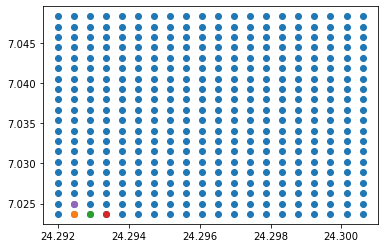

In [7]:
plot_agent(Y)
plot_agent(Y, 1)
plot_agent(Y, 2)
plot_agent(Y, 3)
plot_agent(Y, 21)
# plot_agent(RX, np.arange(len(RX)))

In [8]:
geodesic(Y[1, :], Y[2, :]).km, geodesic(Y[1, :], Y[21, :]).km, geodesic(Y[2, :], Y[3, :]).km

(0.05013458955215821, 0.13197666219604717, 0.050134592538090425)

In [11]:
class Extractor(object):
    def __init__(self, cir_profile):
      self.cir_profile = cir_profile

    def clean_input(self):
      T, S = self.cir_profile.shape
      x_pre = []
      for j in range(T):
          cir_t = [] # channel impulse response for a transmitter
          for i in range(S):
              c_tmp = self.cir_profile[j, i].copy()
              c_tmp[0, :] = c_tmp[0, :] * 10 ** mag # normalize the delay seconds
              
              m, n = c_tmp.shape
              if m == 2:
                  c_tmp[1, :] = abs(c_tmp[1, :])
                  
              cir_shaped = np.pad(c_tmp, \
                  ((0,2-m), (0, max_reflection-n)), \
                      constant_values=0).flatten() # padding 0 to shape of (2, max_len)
              cir_t.append(np.array(cir_shaped, dtype='float'))
              # cir_t.append(np.array(cir_shaped[0: 2], dtype='float'))

          x_pre.append(np.array(cir_t).flatten())

      self.X = np.array(x_pre)
      return self.X

In [222]:
from functools import reduce


ray_len = []
delay_set = []
time_range = []
theta_lst = []
amp_lst = []
sigma_lst = []

for chs in cir_profile:
    theta_lst.append([ch[0, :] for ch in chs])
    amp_lst.append([ch[1, :] for ch in chs])
    sigma_lst.append([1e-13 / np.abs(ch[1, :] ** 2) for  ch in chs])

    for ch in chs:
        ray_len.append(len(ch[0,:]))
        delay_set.extend(ch[0, :])
        time_range.append(max(ch[0, :]))
        # sig_lst.append

max_reflection = max(ray_len)
mag = - math.floor(math.log(np.mean(delay_set), 10))

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


In [223]:
theta_mtx = np.reshape(np.array(theta_lst, dtype='object'), newshape=(4,-1)).T
sigma_mtx = np.reshape(np.array(sigma_lst, dtype='object'), newshape=(4,-1)).T

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\transforms.py:1969: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


Text(0.5, 1.0, 'Distribution of delaying time')

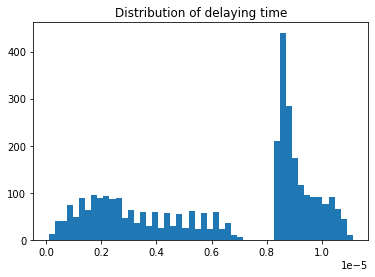

In [14]:
_ = plt.hist(delay_set, bins=50)
plt.title('Distribution of delaying time')

Text(0.5, 0, '#-of-raytraces')

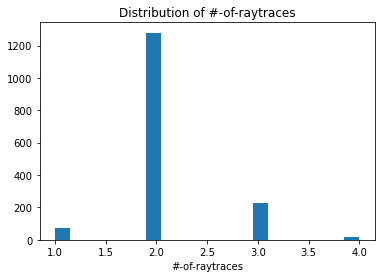

In [313]:
_ = plt.hist(ray_len, bins=20)
plt.title('Distribution of #-of-raytraces')
plt.xlabel('#-of-raytraces')

In [15]:
# prepare X

T, S = cir_profile.shape
x_pre = []
for j in range(T):
    cir_t = [] # channel impulse response for a transmitter
    for i in range(S):
        c_tmp = cir_profile[j, i].copy()
        c_tmp[0, :] = c_tmp[0, :] * 10 ** mag # normalize the delay seconds
        
        m, n = c_tmp.shape
        if m == 2:
            c_tmp[1, :] = abs(c_tmp[1, :])
            
        cir_shaped = np.pad(c_tmp, \
            ((0,2-m), (0, max_reflection-n)), \
                constant_values=0).flatten() # padding 0 to shape of (2, max_len)
        cir_t.append(np.array(cir_shaped, dtype='float'))
        # cir_t.append(np.array(cir_shaped[0: 2], dtype='float'))

    x_pre.append(np.array(cir_t).flatten())

X = np.array(x_pre)  

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<StemContainer object of 3 artists>

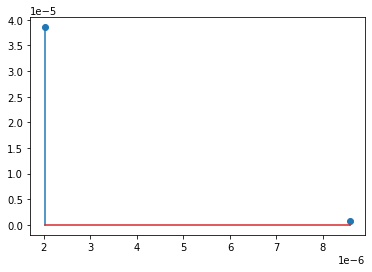

In [16]:
t = cir_profile[10,0]
plt.stem(t[0,:], t[1, :])

# Learning

In [259]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RF

In [255]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Y = meta_data[str(location)+'_cell'][0][0]['tx'].T # lat, lon
Y[0, :], Y[1, :] = Y[1, :], Y[0, :] # change the order of lat and lon increases the accuracy (lon, lat)
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, train_size=.75)
xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=1000, eta=0.1, subsample=1, colsample_bytree=1, reg_lambda=0)
# xgb_reg = xgb.XGBRegressor()
model = MultiOutputRegressor(xgb_reg)

_ = model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

In [267]:
rf = RF(max_depth=1000)
_ = rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
mse_rf = mean_squared_error(y_test, y_pred)
mse_rf, mean_squared_error(y_train, rf.predict(x_train))

(1.2411544999749748e-07, 3.182178638819303e-08)

In [256]:
mse,  mean_squared_error(y_train, model.predict(x_train))

(2.944368740092378e-07, 2.655528709394044e-07)

Text(0, 0.5, 'Longitude')

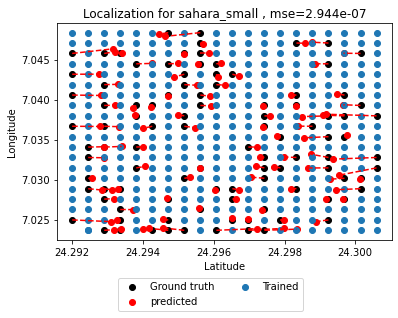

In [271]:
fig, ax = plt.subplots()

ax.scatter(y_test[:, 0], y_test[:, 1], color='k', label='Ground truth')
ax.plot([y_test.T[0, :], y_pred.T[0, :]], [y_test.T[1, :], y_pred.T[1, :]], '--', c='r')
ax.scatter(y_pred[:, 0], y_pred[:,1], color='r', label='predicted')
ax.scatter(y_train[:, 0], y_train[:, 1], label='Trained')
ax.set_title(f'Localization for {location} , mse={round(mse,10)}')
# ax.legend(loc='best')
ax.legend(ncol=2, bbox_to_anchor=(.75, -.15))
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')


In [366]:
geodesic(Y[1, :], Y[21, :]), geodesic(Y[1, :], Y[2, :])

(Distance(0.050386644419336636), Distance(0.14374656269245825))

Text(0.5, 1.0, 'Localization for sahara_small , mse=0.0')

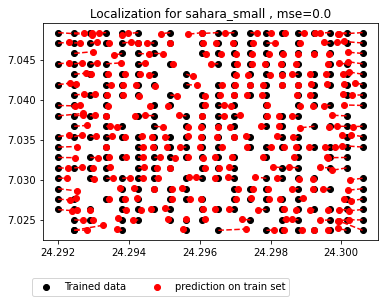

In [270]:
fig, ax = plt.subplots()

y_t = rf.predict(x_train)
ax.scatter(y_train[:, 0], y_train[:, 1], color='k', label='Trained data')
ax.plot([y_train.T[0, :], y_t.T[0, :]], [y_train.T[1, :], y_t.T[1, :]], '--', c='r')
ax.scatter(y_t[:, 0], y_t[:,1], color='r', label='prediction on train set')
ax.legend(ncol=2, bbox_to_anchor=(.75, -.15))
ax.set_title(f'Localization for {location} , mse={round(mse,6)}')


Text(0, 0.5, 'Latitude')

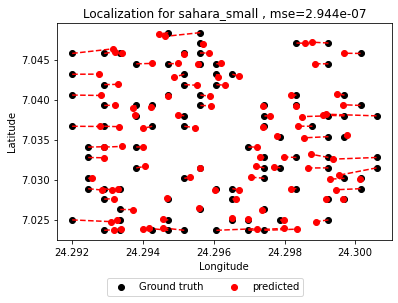

In [273]:
fig, ax = plt.subplots()

ax.scatter(y_test[:, 0], y_test[:, 1], color='k', label='Ground truth')
ax.plot([y_test.T[0, :], y_pred.T[0, :]], [y_test.T[1, :], y_pred.T[1, :]], '--', c='r')
ax.scatter(y_pred[:, 0], y_pred[:,1], color='r', label='predicted')
ax.set_title(f'Localization for {location} , mse={round(mse,10)}')
# ax.legend(loc='best')
ax.legend(ncol=2, bbox_to_anchor=(.75, -.15))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [265]:
dist = [geodesic(i, j).km for i, j in zip(y_test, y_pred)]


Text(0.5, 1.0, 'Distribution of estimation error')

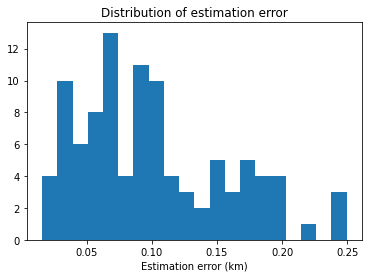

In [266]:
plt.hist(dist, bins=20)
plt.xlabel('Estimation error (km)')
plt.title('Distribution of estimation error')

Text(0.5, 1.0, 'Distribution of estimation error')

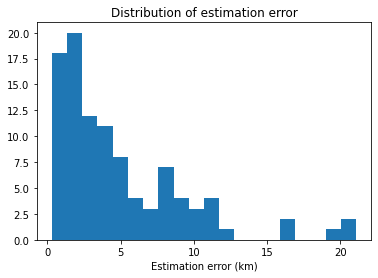

In [387]:
plt.hist(dist, bins=20)
plt.xlabel('Estimation error (km)')
plt.title('Distribution of estimation error')

(array([ 4.,  4.,  9., 13., 12., 12.,  4., 10.,  6.,  6.,  7.,  0.,  5.,
         1.,  2.,  1.,  2.,  1.,  0.,  1.]),
 array([0.07764464, 0.21095598, 0.34426731, 0.47757864, 0.61088997,
        0.7442013 , 0.87751264, 1.01082397, 1.1441353 , 1.27744663,
        1.41075796, 1.54406929, 1.67738063, 1.81069196, 1.94400329,
        2.07731462, 2.21062595, 2.34393729, 2.47724862, 2.61055995,
        2.74387128]),
 <a list of 20 Patch objects>)

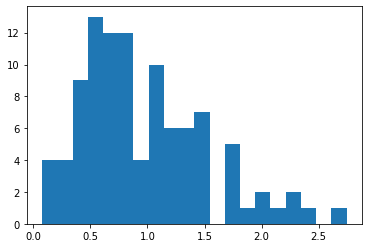

In [163]:
plt.hist(dist, bins=20)

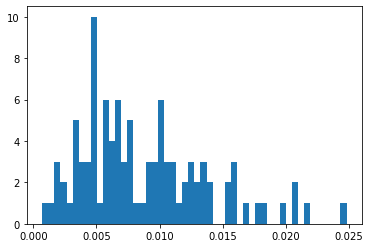

In [83]:
_ = plt.hist(diff.diagonal(), bins=50)

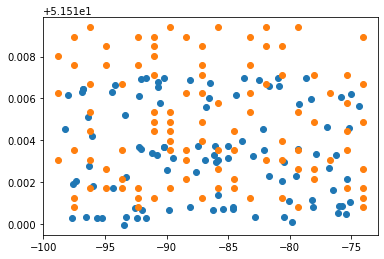

In [419]:
plt.scatter(y_pred[:, 0], y_pred[:,1])
plt.scatter(y_test[:, 0], y_test[:, 1])

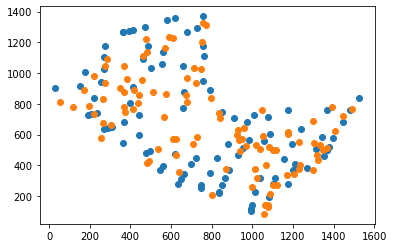

In [27]:
plt.scatter(y_test[:, 0], y_test[:, 2])
plt.scatter(y_pred[:, 0], y_pred[:, 2])

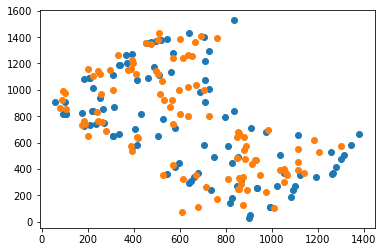

In [28]:
plt.scatter(y_test[:, 3], y_test[:, 1])
plt.scatter(y_pred[:, 3], y_pred[:, 1])

## Extreme learning machine

# Statistical learning

In [137]:
import scipy.stats as stats
from scipy.special import erf 
from math import isclose

In [145]:
def Q(x):
    '''Gaussian Q function'''
    return .5 - .5  * erf(x / np.sqrt(2))

In [224]:
global p_NL, p_E 
p_NL = .5 # probability of all delays are from NLOS path
P_E = .5 # weights of NL,E in NL,E and NL,M sources
eta = 1e6# parameter for exponential distribution of NL,M, depending on channel

def p_ai(a_i, L):
    if a_i == 0:
        return p_NL
    elif a_i > 0 and a_i <= L:
        return (1 - p_NL) / L
    else:
        return 0

def f_L(theta, p_a, p_i):
    return 1 if isclose(theta, geodesic(p_a, p_i).m / 3e8, rel_tol=.05) else 0

def f_NL(theta, p_a, p_i):
    theta_min = geodesic(p_a, p_i).m / 3e8
    theta_max = max(delay_set) # predefined maximum possible delay
    print(f_NLE(theta, theta_max), f_NLM(theta, theta_min, theta_max))
    return P_E * f_NLE(theta, theta_max) + (1 - P_E) * f_NLM(theta, theta_min, theta_max)

def f_NLM(theta, theta_min, theta_max):
    return eta * np.exp(-eta * (theta - theta_min)) / (1 - np.exp(-eta * (theta_max - theta_min))) \
        if theta >= theta_min and theta < theta_max \
            else 0

def f_NLE(theta, theta_max):
    return 1 / theta_max if theta >= 0 and theta < theta_max else 0

def f_anchor_i_ai(theta_arr, p_a, p_i, a_i):
    '''conditional prob of anchor i given p_a, p_i, a_i 
    theta_arr reprents the entire theta arr in CIR for anchor i'''
    return np.prod([f_NL(theta, p_a, p_i) for theta in theta_arr]) if a_i == 0 \
        else f_L(theta_arr[a_i]) * np.prod([f_NL(theta, p_a, p_i) for theta in theta_arr if theta != theta_arr[a_i]])

def f_anchor_i(theta_arr, p_a, p_i):
    # conditional prob of anchor i given p_a, p_i
    L = len(theta_arr)
    # LOS term
    los_term = 0
    for a_i in range(L):
        los_term += f_L(theta_arr[a_i], p_a, p_i) * \
            np.prod([f_NL(theta, p_a, p_i) for theta in theta_arr if theta != theta_arr[a_i]])
        # if f_L(theta_arr[a_i], p_a, p_i) == 1:
        #     print('los term is', los_term, np.prod([f_NL(theta, p_a, p_i) for theta in theta_arr if theta != theta_arr[a_i]]))
    return p_NL * np.prod([f_NL(theta, p_a, p_i) for theta in theta_arr]) + \
        (1 - p_NL) / L * los_term

def f_anchor(theta_mtx, p_a, p_i_arr):
    # theta_mtx shape: N * L - num of stations by num of ray traces per station
    return np.prod([f_anchor_i(theta_mtx[i], p_a, p_i_arr[i]) for i in range(len(theta_mtx))])

def m_L(p_a, p_i, tau, sigma):
    return stats.norm(tau, sigma**2).pdf(geodesic(p_a, p_i).m / 3e8)

def m_NL(theta_min, theta_max, tau, sigma):
    return P_E / theta_max * ( Q(-tau/sigma)- Q((theta_max - tau)/sigma) ) + \
            (1 - P_E) * eta * np.exp(eta * theta_min - eta * tau + .5 * eta**2 * sigma**2) * \
                (Q((theta_min - tau + eta*sigma**2) / sigma) - Q((theta_max - tau + eta*sigma**2) / sigma))

def m_i(p_a, p_i, theta_min, theta_max, tau_arr, sigma_arr):
    '''
    message update for anchor i
    '''
    L = len(tau_arr)
    # LOS term
    los_term = 0
    for a_i in range(L):
        los_term += m_L(p_a, p_i, tau_arr[a_i], sigma_arr[a_i]) * \
            np.product([m_NL(theta_min, theta_max, tau_arr[j], sigma_arr[j]) for j in range(0, L) if j != a_i])
    
    return p_NL * np.prod([m_NL(theta_min, theta_max, tau, sigma) for tau, sigma in zip(tau_arr, sigma_arr)]) + \
        (1 - p_NL) / L * los_term

def g(p_a, p_i_arr, tau_mtx, sigma_mtx):
    '''
    Gaussian mixture rings of one agent
    '''
    N = len(p_i_arr)

    def g_i(p_a, p_i, tau_arr, sigma_arr):
        '''
        Gaussian mixture rings
        '''
        L = len(tau_arr)

        return 1 / L * np.sum([m_L(p_a, p_i, tau,  sigma) for tau, sigma in zip(tau_arr, sigma_arr)])

    return np.sum([g_i(p_a, p_i, tau_arr, sigma_arr) for p_i, tau_arr, sigma_arr in zip(p_i_arr, tau_mtx, sigma_mtx)])

In [65]:
geodesic(p_a, p_i).m, np.mean(dist)

(2117.6059633226046, 940.4088208457388)

In [219]:
geodesic(p_a, p_i_arr[1]).m / 3e8, tau

(2.927485457151137e-06, (8.68733776647086e-06+0j))

In [221]:
sigma

7.566585564635818e-09

In [225]:
tau = theta_mtx[1, 1][1]
sigma = sigma_mtx[1, 1][1]
stats.norm(tau, sigma**2).pdf(geodesic(p_a, p_i_arr[1]).m / 3e8), stats.norm(tau, sigma).pdf(tau)

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1835: ComplexWarning: Casting complex values to real discards the imaginary part
  x = np.asarray((x - loc)/scale, dtype=dtyp)


(6932.859934081255, (52.7242145077935+0j))

In [226]:
g(p_a, p_i_arr, theta_mtx[1], sigma_mtx[1])

11472.166716962145

In [147]:
m(p_a, p_i, theta_min, theta_max, [1,2,3], [4,5,6])

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply


(nan+nanj)

In [98]:
def f_t(theta, theta_min, theta_max):
    return eta * np.exp(-eta * (theta - theta_min) ) / (1 - np.exp(-eta * (theta_max - theta_min))) \
        if theta >= theta_min and theta < theta_max \
            else 0

eta=10**9.55
theta_min = geodesic(p_a, p_i).m / 3e8# 0.5 / 3e8
theta_max = max(delay_set)
# theta_max = 15 / 3e8
theta = theta_mtx[0, 0]
f_t(theta[0], theta_min, theta_max)

0

In [124]:
def f_t(theta, theta_min, theta_max):
    return eta * np.exp(-eta * (theta - theta_min) ) / (1 - np.exp(-eta * (theta_max - theta_min))) \
        if theta >= theta_min and theta < theta_max \
            else 0

eta=10**6
theta_min = geodesic(p_a, p_i).m / 3e8# 0.5 / 3e8
theta_max = max(delay_set)
# theta_max = 15 / 3e8
theta = theta_mtx[0, 0]
f_t(theta[0], theta_min, theta_max)

0

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


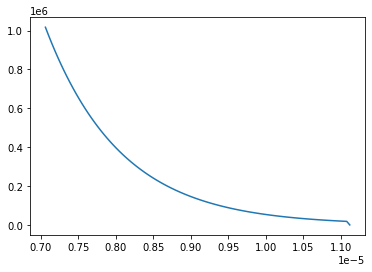

In [125]:
l = []

for i in np.linspace(theta_min, theta_max, 100):
    l.append(f_t(i, theta_min, theta_max))

plt.plot(np.linspace(theta_min, theta_max, 100), l)

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


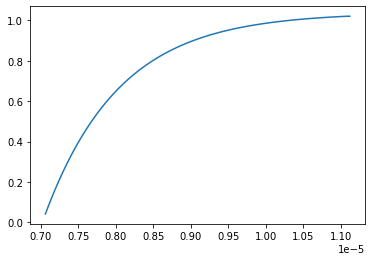

In [126]:
ind = np.linspace(theta_min, theta_max, 100)
np.array(l).shape, ind.shape
new = np.array(l) * (ind[2]-ind[1])
plt.plot(ind, np.cumsum(new))

In [132]:
p_a = p_a_arr[0, :]
p_i = p_i_arr[0, :]
t = theta_mtx[1]

In [20]:
# ta = t[0][0]
# t_min = geodesic(p_a, p_i).m / 3e8
# t_max = max(delay_set)
# eta = .1
# eta * np.exp(-eta * (ta - t_min)*1e6 ) /  (1 - np.exp(-eta * (t_max - t_min)*1e6))

f_anchor_i(t[0], p_a, p_i)

(0.08991061376037132+0j) 0j
(0.08991061376037132+0j) 0j
(0.08991061376037132+0j) 0j
(0.08991061376037132+0j) 0j


C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


(0.0010104898083458341+0j)

In [377]:
ta - t_min, t_max - t_min

((-2.57147222557525e-06+0j), (4.06347087590643e-06+0j))

In [374]:
(1 - np.exp(-eta * (t_max - t_min))), np.exp(-eta * (ta - t_min))
# np.exp(-eta * (ta - t_min) )

(1 - np.exp(-eta * (t_max - t_min)))

(4.063388318054084e-05+0j)

In [351]:
a, b = t_max - t_min, ta-t_min
np.exp(a), (1-np.exp(b))

((1.000009239828409+0j), (-1.04946141865625e-06+0j))

In [356]:
np.exp(b)

(1.0000010494614187+0j)

In [360]:
# f_NL(t[0], p_a, p_i), 
f_NLM(t[0][0], geodesic(p_a, p_i).m / 3e8, max(delay_set))

da is  (108227.81125767989+0j)


(108227.81125767989+0j)

In [323]:
f_anchor_i_ai(t[1], p_a_arr[0, :], p_i_arr[0, :], 0)
# f_anchor_i(t[1], p_a_arr[0], p_i_arr[0])

(5360929867.585775-23457.44773816745j)

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


84

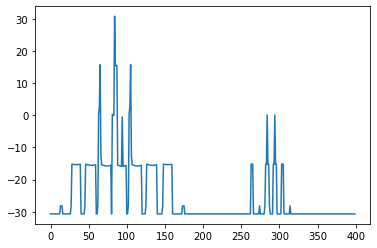

In [422]:
plt.plot(np.log(ls))
np.argmax(ls)

In [143]:
f_anchor(x, p_a_arr[1], p_i_arr)

(3.8240726158929374e+41+0j)

In [145]:
t, p_a

(array([array([0.+0.j]),
        array([0.00000000e+00+0.j, 9.48298179e-07+0.j, 1.42521562e-06+0.j]),
        array([0.+0.j]), array([0.+0.j])], dtype=object),
 array([24.48  ,  7.3426]))

In [128]:
ls = []
ls_2 = []
for p_a in p_a_arr:
    p = f_anchor(theta_mtx[1,:], p_a, p_i_arr)
    ls.append(p)

for t  in theta_mtx:
    ls_2.append(f_anchor(t, p_a, p_i_arr))

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


(0.08991061376037132+0j) (973.8849200844039+0j)
(0.08991061376037132+0j) (350160.4626646022+0j)
(0.08991061376037132+0j) (350160.4626646022+0j)
(0.08991061376037132+0j) (973.8849200844039+0j)
(0.08991061376037132+0j) (3152.44747907355+0j)
(0.08991061376037132+0j) 0
(0.08991061376037132+0j) 0
(0.08991061376037132+0j) (3152.44747907355+0j)
(0.08991061376037132+0j) (52531.43662578784+0j)
(0.08991061376037132+0j) 0
(0.08991061376037132+0j) 0
(0.08991061376037132+0j) (52531.43662578784+0j)
(0.08991061376037132+0j) (32211.919138233246+0j)
(0.08991061376037132+0j) 0
(0.08991061376037132+0j) 0
(0.08991061376037132+0j) (32211.919138233246+0j)
(0.08991061376037132+0j) (923.916077304083+0j)
(0.08991061376037132+0j) (332194.15807775676+0j)
(0.08991061376037132+0j) (332194.15807775676+0j)
(0.08991061376037132+0j) (923.916077304083+0j)
(0.08991061376037132+0j) (2763.2056280123966+0j)
(0.08991061376037132+0j) 0
(0.08991061376037132+0j) 0
(0.08991061376037132+0j) (2763.2056280123966+0j)
(0.08991061376

178

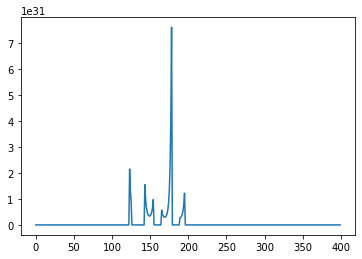

In [129]:
plt.plot(ls)
np.argmax(ls)

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


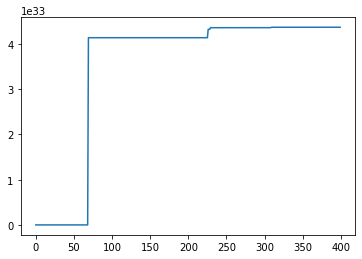

In [130]:
plt.plot(np.cumsum(ls_2))

In [365]:
geodesic(p_a_arr[0], p_i_arr[1]).m / 3e8

2.927485457151137e-06